**1. Data wrangling**

In [52]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# PCA from Scikit-Learn
from sklearn.decomposition import PCA

# Scikit-Learn's make_pipeline function
from sklearn.pipeline import make_pipeline

# Scikit-Learn's KMeans algorithm
from sklearn.cluster import KMeans

In [2]:
# Load data from CSV
tx_df = pd.read_csv('int_online_tx.csv')

In [3]:
# Only keep transactions with CustomerID's
clean_tx_df = tx_df[tx_df.CustomerID.notnull()].copy()

# Convert customer ID's into integers
clean_tx_df['CustomerID'] = clean_tx_df.CustomerID.astype(int)

# Create 'Sales'
clean_tx_df['Sales'] = clean_tx_df.Quantity * clean_tx_df.UnitPrice

In [4]:
# Aggegrate invoice data
invoice_data = clean_tx_df.groupby('CustomerID').InvoiceNo.agg(['nunique'])
invoice_data.columns = ['total_transactions']

In [5]:
# Aggregate cart-level data (at invoice level)
cart_data = clean_tx_df.groupby(['CustomerID' , 'InvoiceNo']).Sales.agg(['sum'])
cart_data.columns = ['cart_value']

# Reset index
cart_data.reset_index(inplace=True)

In [6]:
clean_tx_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583,France,90.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583,France,90.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583,France,45.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583,France,10.2
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583,France,15.6


In [7]:
# Check the number of missing values
clean_tx_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Sales          0
dtype: int64

In [8]:
# Save cleaned transaction level data
clean_tx_df.to_csv('cleaned_transactions.csv', index=None)

In [9]:
# Check the mean number of transactions
invoice_data.total_transactions.mean()


3.710144927536232

In [10]:
# and average cart data value
cart_data.cart_value.mean()

609.8249414062499

Transaction level exploration: check the shape and quality od data and see transaction distribution by country

In [11]:
# Check datafarme dimensions
clean_tx_df.shape

(33698, 9)

In [12]:
# First 10 rows of data
clean_tx_df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583,France,90.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583,France,90.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583,France,45.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583,France,10.2
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583,France,15.6
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583,France,40.8
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583,France,30.0
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583,France,53.1
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583,France,70.8
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583,France,46.8


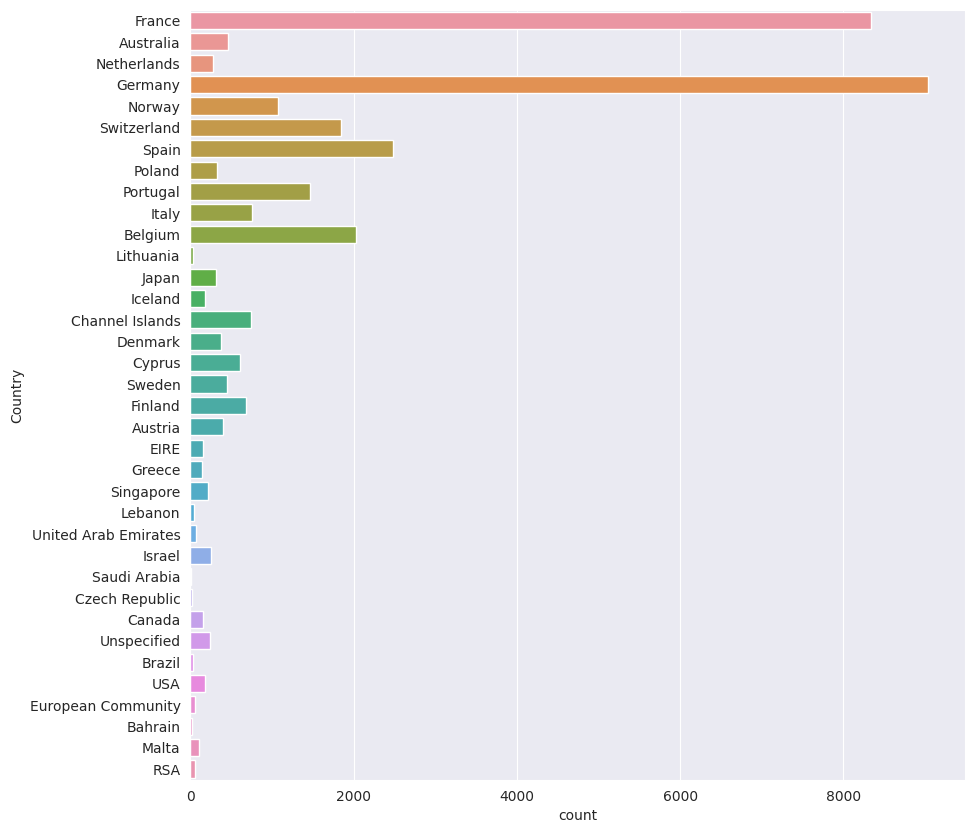

In [13]:
# Make figsize 10x10
plt.figure(figsize=(10,10))

# Bar plot by country
sns.countplot(y='Country', data=clean_tx_df)
plt.show()

We can see that many countries have very sparce classes at the transaction level, which wouldbe even sparcer at customer level since there could be multiple transactons per customer. Clustering by country in this case might not be very efficient.

Customer level aggregation

In [14]:
# Aggregate product data
product_data = clean_tx_df.groupby('CustomerID').StockCode.agg( ['count', 'nunique'] )
product_data.columns = ['total_products', 'total_unique_products']

In [15]:
# Display product data for first 5 customers
product_data.head()

,total_products,total_unique_products
CustomerID,,
12347,182,103
12348,31,22
12349,73,73
12350,17,17
12352,85,59


In [16]:
# Check that for every case total_unique_products is less than total_products
all(product_data.total_products >= product_data.total_unique_products)

True

In [17]:
# Create 2 features: Total sales per customer and average vule of the products by customer
# Roll up sales data
sales_data = clean_tx_df.groupby('CustomerID').Sales.agg( ['sum', 'mean'] )
sales_data.columns = ['total_sales', 'avg_product_value']

# Display sales data for first 5 customers
sales_data.head()

,total_sales,avg_product_value
CustomerID,,
12347,4310.00,23.681319
12348,1797.24,57.975484
12349,1757.55,24.076027
12350,334.40,19.670588
12352,2506.04,29.482824


In [18]:
# Customer level cart data
cart_data.head()

,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91


In [19]:
# Aggregate cart data per customer, create 3 features: average,min and max
agg_cart_data = cart_data.groupby('CustomerID').cart_value.agg(['mean', 'min', 'max'])
agg_cart_data.columns = ['avg_cart_value','min_cart_value','max_cart_value']

# Check data
agg_cart_data.head()

,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347,615.714286,224.82,1294.32
12348,449.310000,227.44,892.80
12349,1757.550000,1757.55,1757.55
12350,334.400000,334.40,334.40
12352,313.255000,120.33,840.30


In [20]:
# Join all the customer level datasets and check the output
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


In [21]:
# Save the final base table
customer_df.to_csv('analytical_base_table.csv')

**2. Dimensionality reduction**

Create individual item level data and introduce threshold

In [22]:
# Read cleaned_transactions.csv
tx_df = pd.read_csv('cleaned_transactions.csv')

In [23]:
# First 10 StockCodes and Descriptions
tx_df[['StockCode', 'Description']].head(10)

,StockCode,Description
0,22728,ALARM CLOCK BAKELIKE PINK
1,22727,ALARM CLOCK BAKELIKE RED
2,22726,ALARM CLOCK BAKELIKE GREEN
3,21724,PANDA AND BUNNIES STICKER SHEET
4,21883,STARS GIFT TAPE
5,10002,INFLATABLE POLITICAL GLOBE
6,21791,VINTAGE HEADS AND TAILS CARD GAME
7,21035,SET/2 RED RETROSPOT TEA TOWELS
8,22326,ROUND SNACK BOXES SET OF4 WOODLAND
9,22629,SPACEBOY LUNCH BOX


In [24]:
# Number of unique items
len(tx_df.StockCode.unique())

2574

In [25]:
# Get item_dummies
item_dummies = pd.get_dummies( tx_df.StockCode )

# Add CustomerID to item_dummies
item_dummies['CustomerID'] = tx_df.CustomerID

# Display first 5 rows of item_dummies
item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST,CustomerID
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583


In [26]:
# Create item_data by aggregating at customer level
item_data = item_dummies.groupby('CustomerID').sum()

# Display first 5 rows of item_data
item_data.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


In [27]:
# Total times each item was purchased
item_data.sum()

10002       12
10120        1
10125       13
10133        5
10135        4
          ... 
90202D       1
90204        1
C2           6
M           34
POST      1055
Length: 2574, dtype: int64

In [28]:
# Save item_data.csv
item_data.to_csv('item_data.csv')

The 2574 customer level item features can be reduced in order to reduce the high dimencionality by introducing thresholding. Here, it will be reduced to 20 most popular items bought.

In [30]:
# Show 20 most popular items
item_data.sum().sort_values().tail(20)

Index(['22961', '22630', '22139', '21080', '85099B', '20726', '20719', '20750',
       '23084', '20725', '21212', '22551', '22629', '22328', '21731', '22556',
       '22554', '22423', '22326', 'POST'],
      dtype='object')


In [31]:
# Get list of StockCodes for those 20 most popular items
top_20_items = item_data.sum().sort_values().tail(20).index
print(top_20_items)

Index(['22961', '22630', '22139', '21080', '85099B', '20726', '20719', '20750',
       '23084', '20725', '21212', '22551', '22629', '22328', '21731', '22556',
       '22554', '22423', '22326', 'POST'],
      dtype='object')


In [32]:
# Keep only features for top 20 items
top_20_item_data = item_data[top_20_items]
top_20_item_data.shape

(414, 20)

In [ ]:
top_20_item_data.head()

In [33]:
# Save threshold_item_data.csv
top_20_item_data.to_csv('threshold_item_data.csv')

**3. PCA (Principal Component Analysis) as another way of reducing high dimensionality**

In [35]:
# Read item_data.csv
item_data = pd.read_csv('item_data.csv', index_col=0)

In [36]:
# Scale all data
#Initialize instance of StandardScaler
scaler = StandardScaler()

# Fit and transform item_data
item_data_scaled = scaler.fit_transform(item_data)

# Display first 5 rows of item_data_scaled
print( item_data_scaled[:5] )

[[-0.13303802 -0.04920678 -0.1119152  ... -0.10482848 -0.15568183
  -0.68068072]
 [-0.13303802 -0.04920678 -0.1119152  ... -0.10482848 -0.15568183
   0.38776219]
 [-0.13303802 -0.04920678 -0.1119152  ... -0.10482848 -0.15568183
  -0.41356999]
 [-0.13303802 -0.04920678 -0.1119152  ... -0.10482848 -0.15568183
  -0.41356999]
 [-0.13303802 -0.04920678 -0.1119152  ... -0.10482848  5.53128397
   0.65487292]]


In [38]:
# Initialise and fit an instance of PCA for all components
# Initialize and fit a PCA transformation
pca = PCA()
pca.fit(item_data_scaled)

PCA()

In [39]:
# Generate new features
PC_items = pca.transform(item_data_scaled)

# Display first 5 rows
print( PC_items[:5] )

[[ 5.87614052e+00  4.82891689e+00 -4.95545069e-01 ... -6.62646278e-04
  -4.43629806e-05  4.38538095e-15]
 [-4.21983747e+00  1.22621722e+00 -1.88191211e+00 ... -2.11471782e-04
  -2.69154340e-04  2.71831169e-15]
 [-1.26084676e+00  2.38766371e+00 -7.31483440e-02 ...  2.57750179e-04
  -2.05682324e-04  3.85455556e-15]
 [-4.92931983e+00 -7.14858724e-01 -1.58093026e+00 ... -1.98603886e-03
   9.92316312e-05  2.55177823e-15]
 [-2.05311348e+00  2.11095022e+00  1.84807021e-01 ... -3.43415269e-04
  -1.32981672e-04 -1.17961196e-16]]


In [40]:
# Sum of explained variance ratio (should be ~1)
pca.explained_variance_ratio_.sum()

1.0

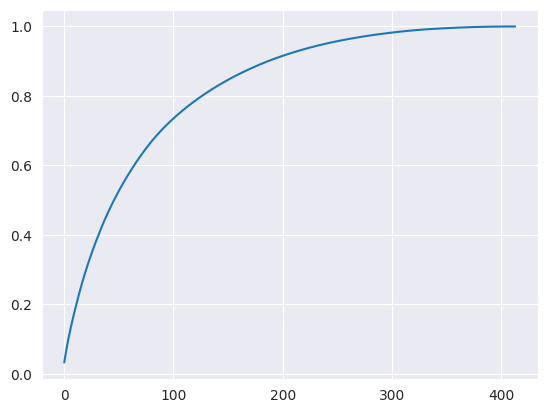

In [41]:
# Cumulative explained variance (total amount of variance captured if kept up to the n-th component)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)
plt.show()

To capture about 80% of the variance, we'd need to keep around 125 components

In [42]:
# How much variance would be captured with the first 125 components
print(cumulative_explained_variance[124])

0.7955069032205401


Reducing 2574 features down to 125 (about 95% fewer features) while capturing almost 80% of the original variance

In [43]:
# Initialize PCA transformation, only keeping 125 components
pca = PCA(n_components=125)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(item_data_scaled)
PC_items.shape

(414, 125)

In [44]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = item_data.index
items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,...,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,5.876141,4.828907,-0.495546,3.093857,-0.633682,-11.534060,2.162003,7.116884,5.336049,4.424298,4.637018,2.316516,12.310908,1.986601,-11.431046,5.617680,-2.177283,7.665966,-12.135627,-16.048808,-5.949656,7.814566,40.518045,-35.574688,-17.557871,6.869191,20.888182,2.298624,-26.156966,-32.582736,7.873131,12.360358,6.828124,-32.958444,-4.420736,-17.242031,-11.269525,-14.484254,-2.761985,4.744302,-6.985427,-1.463814,10.600559,1.238885,3.091505,5.329157,-0.403520,1.410231,-6.429458,3.066618,...,2.245472,2.584862,-0.935281,-1.792919,-1.757733,1.299492,0.474865,-1.372107,-2.072357,-3.512954,0.608770,-1.935398,0.610349,0.428104,1.249189,-1.516038,1.220704,-0.005100,-0.515835,0.673388,-0.871685,-0.211680,-0.111975,-0.211173,-0.134297,-0.495408,-1.372403,-0.548439,-1.329709,0.309149,-0.422744,0.562210,0.856912,-0.789507,0.768289,0.477949,-0.121657,-0.263442,0.719938,0.088320,-0.179107,-0.434362,0.041633,1.252079,0.156951,0.540335,-0.440813,0.064422,-0.157682,-0.232868
12348,-4.219825,1.226263,-1.881811,-0.174294,0.817955,1.161072,-0.871556,-0.846458,0.459913,0.854423,-0.402384,0.981819,-1.104402,0.770617,-0.093017,-0.312979,-0.449300,1.207323,0.380139,-0.468134,0.186975,0.055013,0.498843,0.375593,1.226481,-0.772142,-0.269599,0.853978,-0.370743,-0.573648,1.008941,-0.584432,0.946030,-0.734761,0.358731,-0.390179,-0.292743,0.403191,0.162365,0.337224,-0.453184,0.705111,1.200757,-0.212892,-0.863502,-0.068705,-0.433620,-1.640821,-0.321797,0.470703,...,-1.011305,-0.901225,-0.489631,-0.472932,-0.070479,0.190315,-0.787795,-0.279779,0.732167,0.119972,0.153171,0.076231,-2.176020,0.287138,-0.329977,-0.447308,0.525320,0.833641,-0.740144,0.727603,-0.915042,-0.264677,1.123525,-0.560083,0.869778,1.648416,-0.087722,2.066172,-0.635914,0.166379,0.814776,-1.784970,0.332770,1.357733,0.839039,-0.354100,-0.500740,0.266029,-0.882311,-0.103151,0.491154,-0.798553,-0.884044,0.045313,0.261502,-1.079228,1.523929,-0.821428,1.964709,1.453114
12349,-1.260854,2.387528,-0.073253,-1.119203,-0.034380,-3.715124,-0.343820,-0.149285,-0.788975,-0.379280,1.570674,0.183065,0.223840,-0.050509,3.180712,-0.513325,-1.842718,0.382249,0.316167,-0.001668,-0.419498,0.456137,-0.794635,1.750171,-1.480711,0.757387,-0.913544,0.769874,0.501847,-1.346888,0.294477,0.673985,0.097247,-0.221835,-0.669351,-1.532000,0.785103,-1.427748,-0.099080,-0.902606,0.073436,-0.099314,-0.170718,0.686803,1.378258,-0.265445,-0.117923,-0.147751,0.867818,1.677777,...,2.127808,-0.554244,1.613085,0.784553,1.015383,-0.475630,-0.850053,1.017069,1.397844,-0.514045,1.700447,0.899085,-3.154489,-2.022520,0.134115,-2.683165,-0.628698,-2.220551,-1.183361,-1.822552,-1.162714,0.401121,1.111447,1.534287,0.334843,0.519559,3.121682,-1.588189,-0.116988,-1.224330,-1.004781,-2.458509,0.825355,-1.387356,1.602450,-2.017880,0.813435,4.073057,-3.001238,0.083782,-1.256601,2.905612,-1.574183,0.685162,2.812703,3.429390,2.634562,1.784045,-3.662755,-3.330251
12350,-4.929316,-0.714815,-1.580910,-0.469758,-0.116316,0.647827,0.112906,-1.336439,1.547052,-1.190379,-0.212843,1.057085,-0.475019,0.856498,-1.305648,0.243661,0.268519,1.952586,-0.227791,0.570767,-0.186275,0.903969,1.364138,0.176621,-0.258781,-0.168374,-0.681546,1.083366,-0.153440,-0.397560,0.242774,0.632570,-1.449049,-0.184922,-0.322172,-0.305323,-1.355636,0.002557,0.569595,-0.242971,0.588221,-0.219438,0.287175,0.530478,-0.533408,-0.105073,-1.470137,0.138366,

In [45]:
# Save pca_item_data.csv
items_pca.to_csv('pca_item_data.csv')

**4. K-means clustering**
K-Means creates clusters based on distances that are calculated by between observations defined by their feature values, the features chosen to input into the algorithm heavily influence the clusters that are created.

Here, compare the three options:
1. Only purchase pattern features ("Base DF") - 8 features
2. Purchase pattern features + item features chosen by thresholding ("Threshold DF") -20 features
3. Purchase pattern features + principal component features from items ("PCA DF") -125 features

In [47]:
# Import analytical base table
base_df = pd.read_csv('analytical_base_table.csv', index_col=0)

# Import thresholded item features
threshold_item_data = pd.read_csv('threshold_item_data.csv', index_col=0)

# Import PCA item features
pca_item_data = pd.read_csv('pca_item_data.csv', index_col=0)

In [48]:
# Print shape of each dataframe
print( 'base_df:', base_df.shape )
print( 'threshold_item_data:', threshold_item_data.shape )
print( 'pca_item_data:', pca_item_data.shape )

base_df: (414, 8)
threshold_item_data: (414, 20)
pca_item_data: (414, 125)


In [49]:
# Join base_df with threshold_item_data
threshold_df = base_df.join(threshold_item_data)
threshold_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


In [50]:
# Join base_df with pca_item_data
pca_df = base_df.join(pca_item_data)
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876141,4.828907,-0.495546,3.093857,-0.633682,-11.534060,2.162003,7.116884,5.336049,4.424298,4.637018,2.316516,12.310908,1.986601,-11.431046,5.617680,-2.177283,7.665966,-12.135627,-16.048808,-5.949656,7.814566,40.518045,-35.574688,-17.557871,6.869191,20.888182,2.298624,-26.156966,-32.582736,7.873131,12.360358,6.828124,-32.958444,-4.420736,-17.242031,-11.269525,-14.484254,-2.761985,4.744302,-6.985427,-1.463814,...,2.245472,2.584862,-0.935281,-1.792919,-1.757733,1.299492,0.474865,-1.372107,-2.072357,-3.512954,0.608770,-1.935398,0.610349,0.428104,1.249189,-1.516038,1.220704,-0.005100,-0.515835,0.673388,-0.871685,-0.211680,-0.111975,-0.211173,-0.134297,-0.495408,-1.372403,-0.548439,-1.329709,0.309149,-0.422744,0.562210,0.856912,-0.789507,0.768289,0.477949,-0.121657,-0.263442,0.719938,0.088320,-0.179107,-0.434362,0.041633,1.252079,0.156951,0.540335,-0.440813,0.064422,-0.157682,-0.232868
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219825,1.226263,-1.881811,-0.174294,0.817955,1.161072,-0.871556,-0.846458,0.459913,0.854423,-0.402384,0.981819,-1.104402,0.770617,-0.093017,-0.312979,-0.449300,1.207323,0.380139,-0.468134,0.186975,0.055013,0.498843,0.375593,1.226481,-0.772142,-0.269599,0.853978,-0.370743,-0.573648,1.008941,-0.584432,0.946030,-0.734761,0.358731,-0.390179,-0.292743,0.403191,0.162365,0.337224,-0.453184,0.705111,...,-1.011305,-0.901225,-0.489631,-0.472932,-0.070479,0.190315,-0.787795,-0.279779,0.732167,0.119972,0.153171,0.076231,-2.176020,0.287138,-0.329977,-0.447308,0.525320,0.833641,-0.740144,0.727603,-0.915042,-0.264677,1.123525,-0.560083,0.869778,1.648416,-0.087722,2.066172,-0.635914,0.166379,0.814776,-1.784970,0.332770,1.357733,0.839039,-0.354100,-0.500740,0.266029,-0.882311,-0.103151,0.491154,-0.798553,-0.884044,0.045313,0.261502,-1.079228,1.523929,-0.821428,1.964709,1.453114
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260854,2.387528,-0.073253,-1.119203,-0.034380,-3.715124,-0.343820,-0.149285,-0.788975,-0.379280,1.570674,0.183065,0.223840,-0.050509,3.180712,-0.513325,-1.842718,0.382249,0.316167,-0.001668,-0.419498,0.456137,-0.794635,1.750171,-1.480711,0.757387,-0.913544,0.769874,0.501847,-1.346888,0.294477,0.673985,0.097247,-0.221835,-0.669351,-1.532000,0.785103,-1.427748,-0.099080,-0.902606,0.073436,-0.099314,...,2.127808,-0.554244,1.613085,0.784553,1.015383,-0.475630,-0.850053,1.017069,1.397844,-0.514045,1.700447,0.899085,-3.154489,-2.022520,0.134115,-2.683165,-0.628698,-2.220551,-1.183361,-1.822552,-1.162714,0.401121,1.111447,1.534287,0.334843,0.519559,3.121682,-1.588189,-0.116988,-1.224330,-1.004781,-2.458509,0.825355,-1.387356,1.602450,-2.017880,0.813435,4.073057,-3.001238,0.083782,-1.256601,2.905612,-1.574183,0.685162,2.812703,3.429390,2.634562,1.784045,-3.662755,-3.330251
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929316,-0.714815,-1.580910,-0.469758,-0.116316,0.647827,0.112906,-1.336439,1.547052,-1.190379,-0.212843,1.057085,-0.475019,0.856498,-1.305648,0.243661,0.268519,1.952586,-0.227791,0.570767,-0.186275,0.903969,1.364138,0.176621,-0.258781,-0.168374,-0.681546,1.083366,-0.153440,-0.397560,0.242774,0.632570,-1.449049,-0.184922,-0.322172,-0.305323,-1.355636,0.002557,0.569595,-0.242971,0.588

**4.1 Base DF Clustering**

In [53]:
# K-Means model pipeline keeping number of clusters to 3
k_means = make_pipeline(StandardScaler(),
                        KMeans(n_clusters=3, random_state=123))

In [54]:
# Fit K-Means pipeline
k_means.fit(base_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=123))])

In [55]:
# Save clusters to base_df
base_df['cluster'] = k_means.predict(base_df)
base_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,cluster
CustomerID,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,1
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0


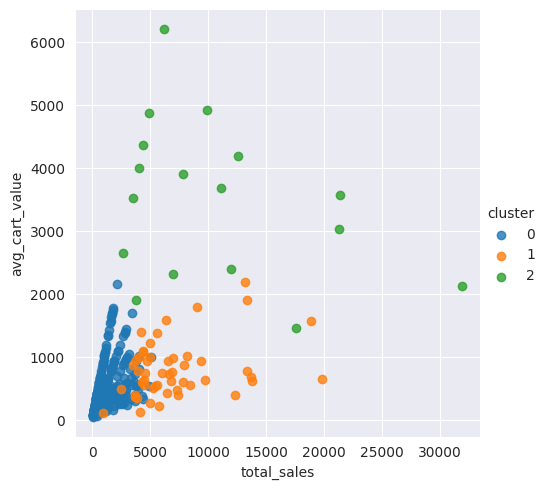

In [56]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster',
           data=base_df, fit_reg=False)
plt.show()

**4.2 Threshold clustering**

In [57]:
# K-Means model pipeline
k_means = make_pipeline(StandardScaler(),
                        KMeans(n_clusters=3, random_state=123))

In [58]:
# Fit K-Means pipeline
k_means.fit(threshold_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=123))])

In [59]:
# Save clusters to threshold_df
threshold_df['cluster'] = k_means.predict(threshold_df)
threshold_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST,cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5,2


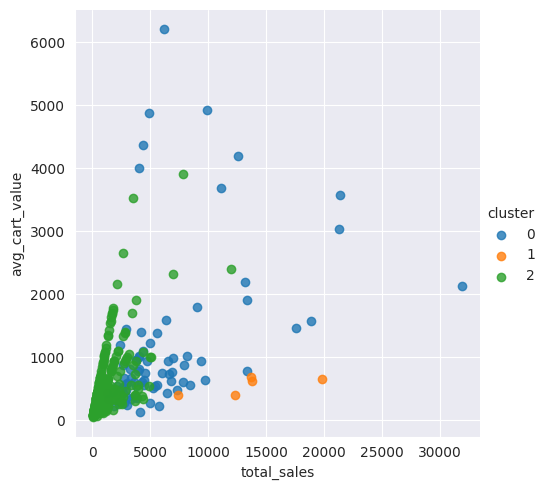

In [60]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster',
           data=threshold_df, fit_reg=False)
plt.show()

**4.3 PCA DF clustering**

In [61]:
# K-Means model pipeline
k_means = make_pipeline(StandardScaler(),
                        KMeans(n_clusters=3, random_state=123))

In [62]:
# Fit K-Means pipeline
k_means.fit(pca_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=123))])

In [63]:
# Save clusters to pca_df
pca_df['cluster'] = k_means.predict(pca_df)
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876141,4.828907,-0.495546,3.093857,-0.633682,-11.534060,2.162003,7.116884,5.336049,4.424298,4.637018,2.316516,12.310908,1.986601,-11.431046,5.617680,-2.177283,7.665966,-12.135627,-16.048808,-5.949656,7.814566,40.518045,-35.574688,-17.557871,6.869191,20.888182,2.298624,-26.156966,-32.582736,7.873131,12.360358,6.828124,-32.958444,-4.420736,-17.242031,-11.269525,-14.484254,-2.761985,4.744302,-6.985427,-1.463814,...,2.584862,-0.935281,-1.792919,-1.757733,1.299492,0.474865,-1.372107,-2.072357,-3.512954,0.608770,-1.935398,0.610349,0.428104,1.249189,-1.516038,1.220704,-0.005100,-0.515835,0.673388,-0.871685,-0.211680,-0.111975,-0.211173,-0.134297,-0.495408,-1.372403,-0.548439,-1.329709,0.309149,-0.422744,0.562210,0.856912,-0.789507,0.768289,0.477949,-0.121657,-0.263442,0.719938,0.088320,-0.179107,-0.434362,0.041633,1.252079,0.156951,0.540335,-0.440813,0.064422,-0.157682,-0.232868,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219825,1.226263,-1.881811,-0.174294,0.817955,1.161072,-0.871556,-0.846458,0.459913,0.854423,-0.402384,0.981819,-1.104402,0.770617,-0.093017,-0.312979,-0.449300,1.207323,0.380139,-0.468134,0.186975,0.055013,0.498843,0.375593,1.226481,-0.772142,-0.269599,0.853978,-0.370743,-0.573648,1.008941,-0.584432,0.946030,-0.734761,0.358731,-0.390179,-0.292743,0.403191,0.162365,0.337224,-0.453184,0.705111,...,-0.901225,-0.489631,-0.472932,-0.070479,0.190315,-0.787795,-0.279779,0.732167,0.119972,0.153171,0.076231,-2.176020,0.287138,-0.329977,-0.447308,0.525320,0.833641,-0.740144,0.727603,-0.915042,-0.264677,1.123525,-0.560083,0.869778,1.648416,-0.087722,2.066172,-0.635914,0.166379,0.814776,-1.784970,0.332770,1.357733,0.839039,-0.354100,-0.500740,0.266029,-0.882311,-0.103151,0.491154,-0.798553,-0.884044,0.045313,0.261502,-1.079228,1.523929,-0.821428,1.964709,1.453114,1
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260854,2.387528,-0.073253,-1.119203,-0.034380,-3.715124,-0.343820,-0.149285,-0.788975,-0.379280,1.570674,0.183065,0.223840,-0.050509,3.180712,-0.513325,-1.842718,0.382249,0.316167,-0.001668,-0.419498,0.456137,-0.794635,1.750171,-1.480711,0.757387,-0.913544,0.769874,0.501847,-1.346888,0.294477,0.673985,0.097247,-0.221835,-0.669351,-1.532000,0.785103,-1.427748,-0.099080,-0.902606,0.073436,-0.099314,...,-0.554244,1.613085,0.784553,1.015383,-0.475630,-0.850053,1.017069,1.397844,-0.514045,1.700447,0.899085,-3.154489,-2.022520,0.134115,-2.683165,-0.628698,-2.220551,-1.183361,-1.822552,-1.162714,0.401121,1.111447,1.534287,0.334843,0.519559,3.121682,-1.588189,-0.116988,-1.224330,-1.004781,-2.458509,0.825355,-1.387356,1.602450,-2.017880,0.813435,4.073057,-3.001238,0.083782,-1.256601,2.905612,-1.574183,0.685162,2.812703,3.429390,2.634562,1.784045,-3.662755,-3.330251,1
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929316,-0.714815,-1.580910,-0.469758,-0.116316,0.647827,0.112906,-1.336439,1.547052,-1.190379,-0.212843,1.057085,-0.475019,0.856498,-1.305648,0.243661,0.268519,1.952586,-0.227791,0.570767,-0.186275,0.903969,1.364138,0.176621,-0.258781,-0.168374,-0.681546,1.083366,-0.153440,-0.397560,0.242774,0.632570,-1.449049,-0.184922,-0.322172,-0.305323,-1.355636,0.002557,0.569595,-0.242971,0.588221,-0.219438,...,-

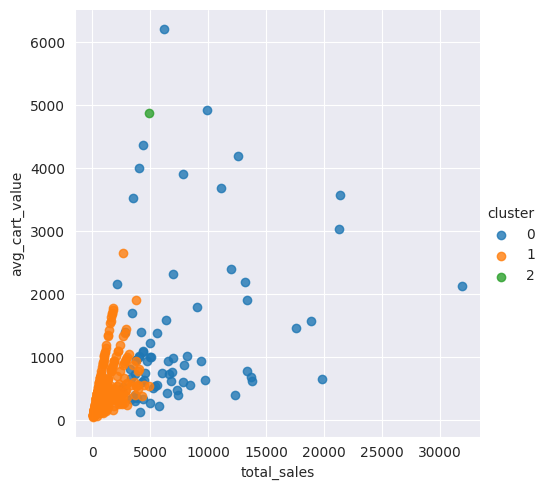

In [64]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster',
           data=pca_df, fit_reg=False)
plt.show()

**4.4 Model Comparison**

The adjusted Rand index is a similarity measure between two clusterings. It counts the observations that were assigned to the same or different clusters by two different clusterings.
Values close to 0.0 indicate random/independent clusters,
values close to 1.0 indicate nearly identical clusters

In [65]:
# Adjusted Rand index
from sklearn.metrics import adjusted_rand_score

In [66]:
# Similarity between base_df.cluster and threshold_df.cluster
adjusted_rand_score(base_df.cluster, threshold_df.cluster)

0.6021354951782343

In [67]:
# Similarity between base_df.cluster and pca_df.cluster
adjusted_rand_score(base_df.cluster, pca_df.cluster)

0.7731287777027831

In [68]:
# Similarity between threshold_df.cluster and pca_df.cluster
adjusted_rand_score(threshold_df.cluster, pca_df.cluster)

0.6159331176675547